<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10

Número de regiones propuestas: 3057


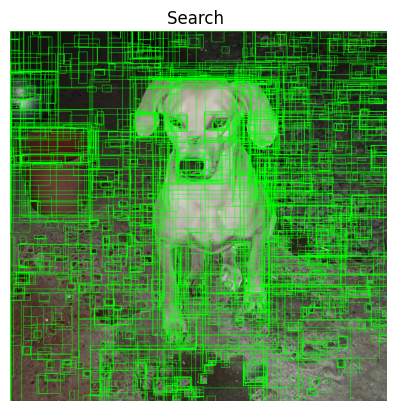

In [5]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/akina.png')

def get_Region_Proposals(img,max_regiones=2000):
# Crear un objeto de Selective Search
 ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Configurar la imagen para Selective Search
 ss.setBaseImage(img)

# Modo rápido o calidad

 ss.switchToSelectiveSearchFast()  # Más rápido pero menos preciso

 #ss.switchToSelectiveSearchQuality()  # Más preciso pero más lento

# Ejecutar Selective Search para obtener las regiones propuestas
 rects = ss.process()

 print(f"Número de regiones propuestas: {len(rects)}")

 return rects[:max_regiones]


rectas_propuestas=get_Region_Proposals(image)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dibujar las regiones propuestas en la imagen
for (x, y, w, h) in rectas_propuestas:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

(224, 224, 3)


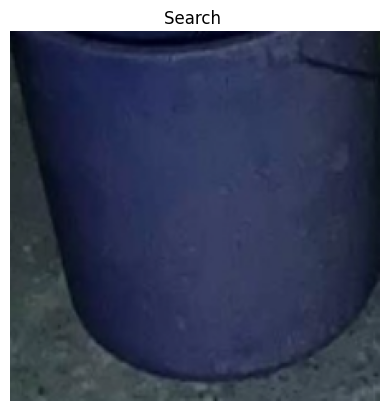

In [6]:
#Funcion redimension dee regiones para entrada al cnn:

def extract_region(image,rect,size=(224,224)):
  x=rect[0]
  y=rect[1]
  w=rect[2]
  h=rect[3]

  region=image[y:y+h, x:x+w] #crop imagen segun recta

  img_region=cv2.resize(region, size) #redimensionar para entrada a vgg16 imanges 224x224

  return img_region

img=extract_region(image,rectas_propuestas[900])

print(img.shape)

plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [7]:
#Leer arhcivos xml:
import os
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_file):
    """Parses a Pascal VOC XML file and returns labels and bounding boxes."""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Información de la imagen
    image_info = {
        "filename": root.find("filename").text,
        "size": {
            "width": int(root.find("size/width").text),
            "height": int(root.find("size/height").text),
            "depth": int(root.find("size/depth").text),
        },
        "objects": []
    }

    # Iterar sobre los objetos que tiene la imagen
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = [int(obj.find("bndbox/xmin").text),int(obj.find("bndbox/ymin").text), int(obj.find("bndbox/xmax").text),int(obj.find("bndbox/ymax").text)]
        image_info["objects"].append({"label": label, "bbox": bbox})

    return image_info



In [8]:
#funcion calcular iou para comparar la region propuesta con la real:

def calculateIoU(real_bb,predict_bb):

   xl=max(real_bb[0],predict_bb[0]) #maximo entre x de cada extremo top_left de cada bounidnig box
   yl=max(real_bb[1],predict_bb[1]) #maximo entre y de cada extremo top_left de cada bounidnig box

   xr=min(real_bb[2],predict_bb[2]) #min entre x de cada extremo bottom_right de cada bounidnig box
   yr=min(real_bb[3],predict_bb[3]) #min entre y de cada extremo bottom_right de cada bounidnig box

   intersecion_area=(xr-xl)*(yr-yl)  #calculamos el area de la interseccion

   area_realbb=(real_bb[2]-real_bb[0])*(real_bb[3]-real_bb[1]) # calculamos el area del bounding box real con cada una de sus coedenadas
   area_predictbb=(predict_bb[2]-predict_bb[0])*(predict_bb[3]-predict_bb[1]) #calculamos el area del boudnign box predicho con cada una de sus coedenadas

   union_area= (area_realbb + area_predictbb)- intersecion_area #Calculamos el area de la union

   IoU= intersecion_area/union_area #calculamos IoU dividiendo la interesccion con la union

   return IoU





In [19]:
#Selecionar regiones propuestas que iran al  modelo SVM  usando criterio de IoU donde  <0.3 sera considerados como fondo ,0.3< IoU <0.5 sera omitido para evitar ambuiguidad
#Mayores a 0.5> sera clasificado como la clase del bbox que mas se apropixma al IoU.

def select_labels_regiones(regiones, ground_truth_boxes, ground_truth_labels, iou_threshold=0.7):

  labels=[]
  regiones_selected=[]
  real_bbox_selected=[]
  for region in regiones:
    max_iou = 0
    best_label = 'fondo'  # Inicializar como fondo por defecto
    best_box = None

    for box, gt_label in zip(ground_truth_boxes, ground_truth_labels):

        iou = calculateIoU(region, box)
        if iou > max_iou:  #se quedara con el mayor iou conseguido de los objetos que coincida asi no tener probelmas de etiquetar fondo si se pasa a los siguientes boxes
            max_iou = iou
            if iou <=0.3:
              best_label = 'fondo'
              best_box = None

            elif  0.3<iou<iou_threshold:
               best_label = 'no seleccionada'
               best_box = None

            elif  iou >= iou_threshold:  # Verifica si el IoU supera el umbral
                best_label = gt_label
                best_box = box

    if best_label != 'no seleccionada':
     regiones_selected.append(region)
     real_bbox_selected.append(best_box)
     labels.append(best_label)


  return regiones_selected,real_bbox_selected,labels

#selecionamos el bbox real de cada bbox que se propuesto y contenga un objeto (iou>0.7) y no consideremos el fondo, esto para entrenar el modelo regresor

def select_bbox_regiones(regiones_selected,real_regiones_selected,labels):

    real_bboxs=[]
    regiones=[]
    labels_selected=[]
    for region,real_bbox,label in zip(regiones_selected,real_regiones_selected,labels):

        if label!='fondo':
            real_bboxs.append(real_bbox)
            regiones.append(region)
            labels_selected.append(label)



    return regiones,real_bboxs,labels_selected





In [43]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion

def calculate_translations(bbox_pred, bbox_real, epsilon = 1e-10):
    """
    Calcula los desplazamientos (t_x, t_y, t_w, t_h) para ajustar las cajas de referencia a las cajas de verdad.

    :param xmin_pred, ymin_pred, xmax_pred, ymax_pred: coordenadas extremas de la caja de la verdad (ground truth)
    :param xmin_ref, ymin_ref, xmax_ref, ymax_ref: coordenadas extremas de la caja de referencia (anchor box)
    :return: desplazamientos t_x, t_y, t_w, t_h
    """
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox_pred
    xmin_real, ymin_real, xmax_real, ymax_real=bbox_real

    # Paso 1: Calcular el centro y el tamaño de la caja de referencia
    real_w = xmax_real - xmin_real
    real_h = ymax_real - ymin_real
    real_cx = (xmin_real + xmax_real) / 2
    real_cy = (ymin_real + ymax_real) / 2

    # Paso 2: Calcular el centro y el tamaño de la caja de la verdad
    gt_w = xmax_pred - xmin_pred
    gt_h = ymax_pred - ymin_pred
    gt_cx = (xmin_pred + xmax_pred) / 2
    gt_cy = (ymin_pred + ymax_pred) / 2

    # Validación para evitar valores inválidos en anchuras y alturas
    real_w = max(real_w, epsilon)
    real_h = max(real_h, epsilon)
    gt_w = max(gt_w, epsilon)
    gt_h = max(gt_h, epsilon)

    # Paso 3: Calcular los desplazamientos (t_x, t_y, t_w, t_h)
    t_x = (gt_cx - real_cx) / (real_w+epsilon)
    t_y = (gt_cy - real_cy) / (real_h+epsilon)
    t_w = np.log(gt_w / (real_w +epsilon))
    t_h = np.log(gt_h / (real_h+epsilon) )


    return [t_x, t_y, t_w, t_h]

import numpy as np

def apply_translations_to_proposed_bbox(bbox_pred, translations, epsilon=1e-10): #hcer lo inverso y pasar las transformaciones aplciadas a bbox predicho para calcular bboxreal
    """
    Aplica las translaciones a un bounding box propuesto para calcular el bounding box real (ground truth).

    :param bbox_pred: Bounding box propuesto (xmin_pred, ymin_pred, xmax_pred, ymax_pred).
    :param translations: Lista de translaciones [t_x, t_y, t_w, t_h].
    :param epsilon: Valor pequeño para evitar divisiones por cero en los cálculos.
    :return: Bounding box real (xmin_real, ymin_real, xmax_real, ymax_real).
    """
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox_pred
    t_x, t_y, t_w, t_h = translations

    # Paso 1: Calcular el centro y el tamaño de la caja propuesta (predicha)
    pred_w = xmax_pred - xmin_pred
    pred_h = ymax_pred - ymin_pred
    pred_cx = (xmin_pred + xmax_pred) / 2
    pred_cy = (ymin_pred + ymax_pred) / 2

    # Paso 2: Aplicar las translaciones
    real_cx = pred_cx - t_x * (pred_w + epsilon)
    real_cy = pred_cy - t_y * (pred_h + epsilon)
    real_w = pred_w * np.exp(-t_w)  # Usamos el exponente negativo para invertir la relación
    real_h = pred_h * np.exp(-t_h)  # Usamos el exponente negativo para invertir la relación

    # Paso 3: Calcular las nuevas coordenadas del bounding box real
    xmin_real = real_cx - real_w / 2
    ymin_real = real_cy - real_h / 2
    xmax_real = real_cx + real_w / 2
    ymax_real = real_cy + real_h / 2

    return [xmin_real, ymin_real, xmax_real, ymax_real]

In [26]:
#Crear extractor de  features con VGG16:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np


vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# Definir las transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar según ImageNet
])

def extract_features_from_regions(regiones):
    all_features = []



    for region in regiones:

        region_extracted=extract_region(image,region)

        # Convertir la región redimensionada a tensor
        input_tensor = transform(region_extracted).to(device)
        input_tensor = input_tensor.unsqueeze(0)  # Añadir batch dimension
        input_tensor = Variable(input_tensor)

        # Extraer características usando VGG16
        with torch.no_grad():
            features = vgg16.features(input_tensor)  # Extraer las características
            flattened = features.view(features.size(0), -1)
        all_features.append(flattened.squeeze().cpu().numpy())  # Almacenar las características

    return np.array(all_features)



In [37]:
#ENTRENAR CLASFICADOR SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Ruta del directorio que contiene los archivos XML
xml_dir = "/content/dataset/anotaciones"
img_dir='/content/dataset/imagenes'
# Leer todos los archivos XML

svm = SVC(kernel='linear', C=1.0)  # Puedes cambiar el kernel (lineal, RBF, etc.)


for xml_file in sorted(os.listdir(xml_dir)):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(xml_dir, xml_file)
        info = parse_voc_xml(xml_path)

        image = cv2.imread(f"{img_dir}/{info['filename']}")
        ground_truth_boxes=[]
        ground_truth_labels=[]

        for obj in info["objects"]:
           ground_truth_boxes.append(obj['bbox'])
           ground_truth_labels.append(obj['label'])


        regiones_propuestas=get_Region_Proposals(image,max_regiones=2000)

        regiones_selected,real_bbox_selected,labels=select_labels_regiones(regiones_propuestas, ground_truth_boxes, ground_truth_labels)

        features = extract_features_from_regions(regiones_selected)


        #label_encoder = LabelEncoder()
        #label_regiones_propuestas_encoder = label_encoder.fit_transform(labels)
        #print(labels)


        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
        print(y_train)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Precisión del SVM: {accuracy:.2f}")
        print(features.shape)




Número de regiones propuestas: 2621
['gato', 'fondo', 'fondo', 'fondo', 'gato', 'fondo', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'gato', 'gato', 'gato', 'fondo', 'gato', 'fondo', 'fondo', 'fondo', 'fondo', 'gato', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'fondo', 'fondo', 'gato', 'gato', 'gato', 'gato', 'gato', 'gato', 'gato', 'gato', 'gato', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'gato', 'gato', 'gato', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'fondo', 'gato', 'gato', 'gato', 'fondo', 'fondo', 'fondo', 'fondo', 'gato', 'gato', 'gato', 'gato', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'fondo', 'fondo', 'fondo', 'fondo', 'gato', 'fondo', 'fondo', 'gato', 'gato', 'fondo', 'fondo', 'fondo', 'fondo', 'gato', 'fondo', 'gato', 'gato', 'g

In [31]:
#ENTRENTAR REGRESOR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Ruta del directorio que contiene los archivos XML
xml_dir = "/content/Dataset/anotaciones"
img_dir='/content/Dataset/imagenes'
# Leer todos los archivos XML


regressor = LinearRegression()

for xml_file in sorted(os.listdir(xml_dir)):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(xml_dir, xml_file)
        info = parse_voc_xml(xml_path)

        image = cv2.imread(f"{img_dir}/{info['filename']}")
        ground_truth_boxes=[]
        ground_truth_labels=[]

        for obj in info["objects"]:
           ground_truth_boxes.append(obj['bbox'])
           ground_truth_labels.append(obj['label'])


        regiones_propuestas=get_Region_Proposals(image,max_regiones=2000)

        regiones_selected,real_bbox_selected,labels=select_labels_regiones(regiones_propuestas, ground_truth_boxes, ground_truth_labels)

        regiones,real_bboxs,labels_selected=select_bbox_regiones(regiones_selected,real_bbox_selected,labels)

        features = extract_features_from_regions(regiones)
        translations=[]

        for region,truth_box in zip(regiones,real_bboxs):
          translations.append(calculate_translations(region,truth_box))

        print(np.array(translations).shape)
        regressor.fit(features, np.array(translations))






Número de regiones propuestas: 2621
Número de regiones propuestas: 537
Número de regiones propuestas: 2252
Número de regiones propuestas: 563
Número de regiones propuestas: 409
Número de regiones propuestas: 1130
Número de regiones propuestas: 488
Número de regiones propuestas: 562
Número de regiones propuestas: 4192
Número de regiones propuestas: 432
Mean Squared Error (MSE): 0.09167546951994066
R² (Coefficient of Determination): 0.9959989352033558


In [47]:
#prediccion con imagen:


url = "/content/images.jpg"# @param {type:"string"}

image = cv2.imread(url)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

regiones_propuestas=get_Region_Proposals(image_rgb,max_regiones=2000)

features = extract_features_from_regions(regiones_propuestas)

clases=svm.predict(features)

translations=regressor.predict(features)

for clase,translation,region_propuesta in zip(clases,translations,regiones_propuestas):
  if clase != 'fondo':
     print(region_propuesta)
     print(translation)
     pred_bbox=apply_translations_to_proposed_bbox(region_propuesta,translation)
     print(pred_bbox)
     cv2.rectangle(image, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (0, 255, 0), 2)



plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para mostrar solo la imagen
plt.show()


Número de regiones propuestas: 327
[ 35 129  70  31]
[  0.41181993  -0.34712344 -29.869202   -21.614079  ]
[-164084470251481.9, 119418365741.9819, 164084470251558.1, -119418365650.0181]


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2
